In [43]:
%matplotlib inline  
import librosa
import librosa.display
import numpy as np
# import matplotlib.pyplot as plt
from glob import glob
import pickle
import random
import matplotlib.pyplot as plt
import pickle
import soundfile as sf

In [44]:
window_length = 256

overlap = round(0.25 * window_length) # overlap of 75%

n_fft = window_length

feature_sample = 16000

n_features = n_fft//2 + 1

n_segments = 8

n_clean_segments = 1

random_noise_index_max = 10

speech_files = glob('/run/media/svyatoslav/Files/Documents/Speech denoising/data/input/speech/*.mp3')
noise_files = glob('/run/media/svyatoslav/Files/Documents/Speech denoising/data/input/noise/*/*.wav')

In [45]:
# Read audiofiles
def read_audio_file(filepath, sample_rate, normalize = True):
    audio, _ = librosa.load(filepath, sr=sample_rate)
    audio, _ = librosa.effects.trim(audio)
    if normalize:
      div_fac = 1 / np.max(np.abs(audio)) / 3.0
      audio = audio * div_fac
    return audio

np.random.shuffle(noise_files)
np.random.shuffle(speech_files)

X_files = [read_audio_file(files, feature_sample) for files in speech_files[:1]]
noise_files = [read_audio_file(files, feature_sample) for files in noise_files[:random_noise_index_max]]

Y_files = X_files

In [46]:
# Add noise to audio 
def mix_audio(signal, noise, snr):
    noise = noise[np.arange(len(signal)) % len(noise)]
    
    noise = noise.astype(np.float32)
    signal = signal.astype(np.float32)
    
    signal_energy = np.mean(signal**2)
    noise_energy = np.mean(noise**2)

    g = np.sqrt(10.0 ** (-snr/10) * signal_energy / noise_energy)

    a = np.sqrt(1 / (1 + g**2))
    b = np.sqrt(g**2 / (1 + g**2))

    return a * signal + b * noise

def make_some_noise(X_files, noise_files):
    result_list = []
    for files in X_files:
        noise_file_index = np.random.randint(0, random_noise_index_max)
        result_list.append(mix_audio(files, noise_files[noise_file_index], random.randrange(0, 20, 5)))
        
    return result_list

X_files = make_some_noise(X_files, noise_files)

sf.write('noisy_file_example.wav', X_files[0], feature_sample)
sf.write('clean_file_example.wav', Y_files[0], feature_sample)
noise_files.clear()
speech_files.clear()

In [47]:
# Get stft spectrogram
def read_as_stft_spectrogram(audio):
    return librosa.stft(y=audio, n_fft=n_fft,hop_length=overlap, center=True, window='hamming')

def convert_audio_to_image(audio_files):
    return [read_as_stft_spectrogram(items) for items in audio_files]

X = convert_audio_to_image(X_files)
Y = convert_audio_to_image(Y_files)

X_files.clear()
Y_files.clear()

/tmp/ipykernel_164357/2249577668.py:2: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  result = librosa.amplitude_to_db(spectrogram, ref=np.max).astype(np.float32)


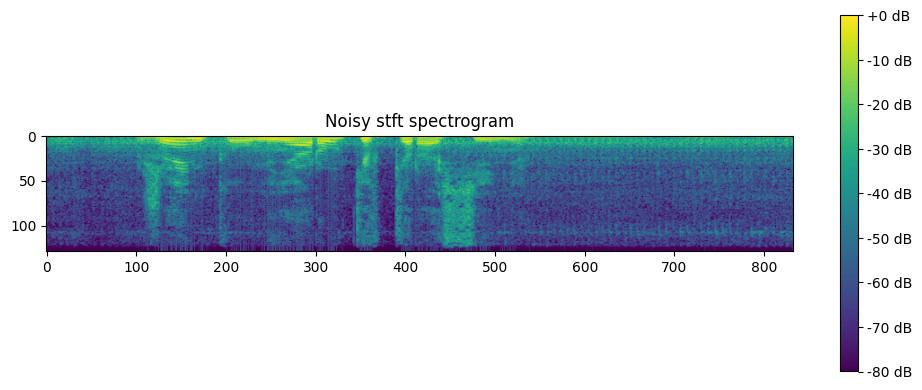

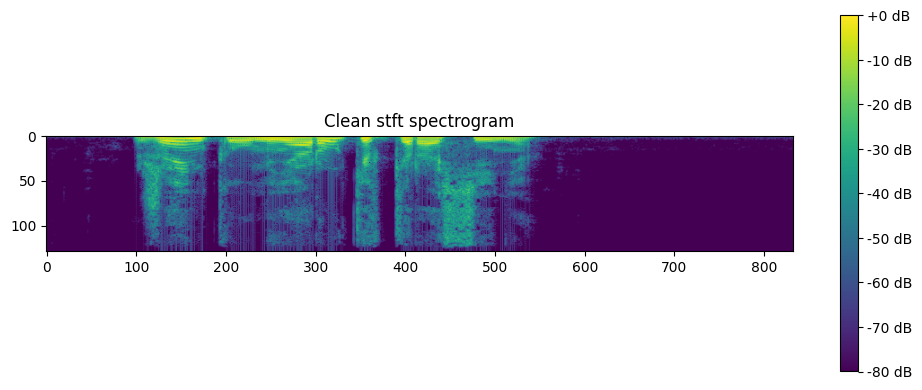

In [48]:
def show_spectrogram(spectrogram, title):
    result = librosa.amplitude_to_db(spectrogram, ref=np.max).astype(np.float32)
    plt.figure(figsize=(10,4))
    plt.imshow(result)
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.tight_layout()

show_spectrogram(X[0], "Noisy stft spectrogram")
show_spectrogram(Y[0], "Clean stft spectrogram")

In [49]:
# Steps according to paper
phase = np.angle(X[0])
pickle.dump(phase, open('phase.pkl', 'wb'))

def means(audio, write_flag):
    stft_feature = np.abs(audio)
    mean = np.mean(stft_feature)
    std = np.std(stft_feature)
    if write_flag:
        params = np.asarray([mean, std])
        pickle.dump(params, open('params.pkl', 'wb'))
    return (stft_feature - mean) / std

X = [means(audio, False) for audio in X]
Y = [means(audio, True) for audio in Y]

In [50]:
def prepare_input_features(stft_features, n_segments):
    stft_feature = np.concatenate([stft_features[:,0:n_segments-1], stft_features], axis=1)
    stft_segments = np.zeros((n_features, n_segments , stft_feature.shape[1] - n_segments + 1))

    for index in range(stft_feature.shape[1] - n_segments + 1):
        stft_segments[:,:,index] = stft_feature[:,index:index + n_segments]
    return stft_segments

X_predictors = [prepare_input_features(stft_feature, n_segments) for stft_feature in X]
Y_predictors = [prepare_input_features(stft_feature, n_clean_segments) for stft_feature in Y]
X.clear()
Y.clear()
print(X_predictors[0].shape, Y_predictors[0].shape)

(129, 8, 833) (129, 1, 833)


In [51]:
def reshape_predictors(predictors):
    predictors = np.reshape(predictors, (predictors.shape[0], predictors.shape[1], 1, predictors.shape[2]))
    predictors = np.transpose(predictors, (3, 0, 1, 2)).astype(np.float32)
    # print('predictors.shape:', predictors.shape)
    return predictors
    
X_predictors = np.asarray([reshape_predictors(predictors) for predictors in X_predictors], dtype=object)
Y_predictors = np.asarray([reshape_predictors(predictors) for predictors in Y_predictors], dtype=object)

In [52]:
# prepare and write dataset 
X_training = f'x_test.pkl'
Y_training = f'y_test.pkl'

pickle.dump(np.concatenate(X_predictors), open(X_training, 'ab')) 
pickle.dump(np.concatenate(Y_predictors), open(Y_training, 'ab'))